In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
from scanf import scanf
import sys

from sklearn.metrics import roc_curve, roc_auc_score

# Own modules
module_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.abspath(module_path))

from src.utils import description_file_utils

dataset_dir = os.path.join(module_path, 'datasets')
filenames_table = description_file_utils.get_param_by_filename_table('fspl', 'measurements')

In [6]:
# Some config (do not change)

method_labels = {'unsupervised_density': 'Unsupervised density',
                 'unsupervised_threshold': 'AED',
                 'one_class_svm': 'OCSVM',
                 'lof': 'LOF',
                 'dbscan': 'DBSCAN',
                 'elliptic_envelope': 'Elliptic envelope'}

method_colors = {'unsupervised_threshold': 'C0',
                 'one_class_svm': 'C1',
                 'dbscan': 'C2',
                 'lof': 'C3',
                 'elliptic_envelope': 'C4',
                 'unsupervised_density': 'C5'}

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False #changed to false by lauren

# Single ROC curves + AUC

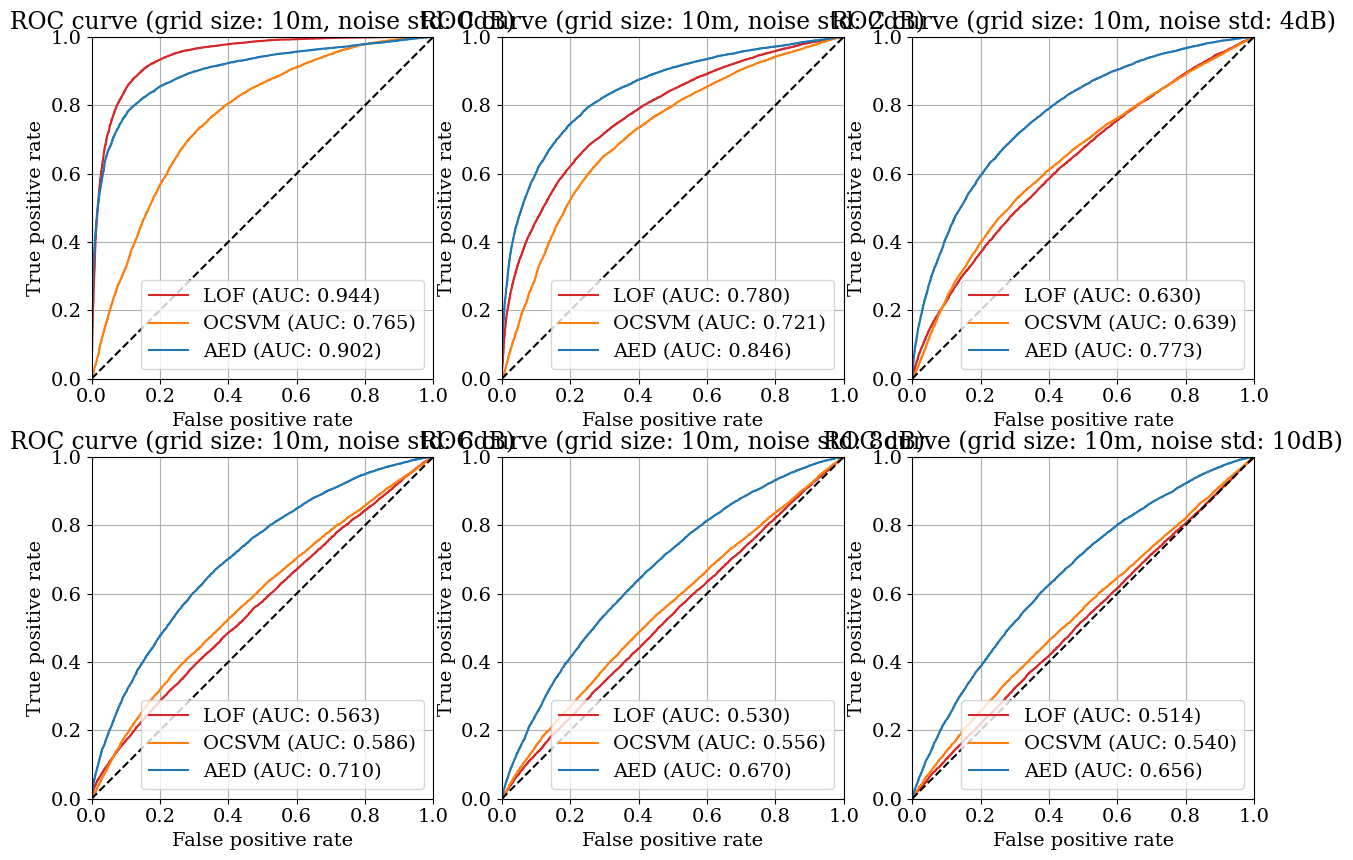

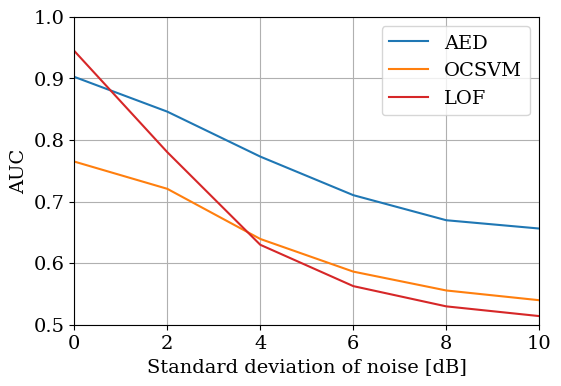

In [7]:
param = 'noise_std'     # 'noise_std' or 'grid_size'

exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']

auc_lists = {method: {} for method in method_labels}

def plot_roc_for_one_config(grid_size, noise_std, ax):

    # Load results from file
    filename = filenames_table.loc[np.logical_and(filenames_table['noise_std'] == noise_std, filenames_table['grid_size'] == grid_size), 'filename'].values[0]
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pkl.load(f_results)

    # Calculate and plot the ROC curve for each method
    for method in results:
        
        if method in exclude_from_plot:
            continue

        if method == 'one_class_svm':
            fpr, tpr, thresholds = roc_curve(results[method]['y_test'], -results[method]['y_hat'])
            auc = roc_auc_score(results[method]['y_test'], 1-results[method]['y_hat'])
        else:
            fpr, tpr, thresholds = roc_curve(results[method]['y_test'], results[method]['y_hat'])
            auc = roc_auc_score(results[method]['y_test'], results[method]['y_hat'])
        if noise_std == 0:
            global r
            r = results['one_class_svm']

        if param == 'noise_std':
            auc_lists[method][noise_std] = auc
        else:
            auc_lists[method][grid_size] = auc
        
        ax.plot(fpr, tpr, color=method_colors[method], label=f'{method_labels[method]} (AUC: {auc:.3f})')

    # Plot the 50-50 line
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_aspect('equal', 'box')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_title(f'ROC curve (grid size: {grid_size}m, noise std: {noise_std}dB)')
    ax.grid()


if param == 'noise_std':
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    for ax_idx, noise_std in enumerate(np.arange(0, 11, 2)):
        plot_roc_for_one_config(10, noise_std, ax[np.floor(ax_idx/3).astype(int), ax_idx%3])
    plt.show()

elif param == 'grid_size':
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for ax_idx, grid_size in enumerate(np.arange(5, 25, 5)):
        plot_roc_for_one_config(grid_size, 2, ax[np.floor(ax_idx/2).astype(int), ax_idx%2])
    plt.show()


plt.rcParams['font.size'] = 14
plt.figure(figsize=(6,4))
for method in auc_lists:
    if method in exclude_from_plot:
        continue
    plt.plot(auc_lists[method].keys(), auc_lists[method].values(), color=method_colors[method], label=method_labels[method])
if param == 'noise_std':
    plt.xlabel('Standard deviation of noise [dB]')
else:
    plt.xlabel('Grid size [m]')
plt.ylabel('AUC')
if param == 'noise_std':
    plt.xlim([0, 10])
elif param == 'grid_size':
    plt.xlim([5, 20])
plt.ylim([0.5, 1])
plt.grid()
plt.legend()
figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', f'auc-vs-{param}.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.rcParams['font.size'] = 14

# ROC curves for two shadowing levels / grid sizes in one plot

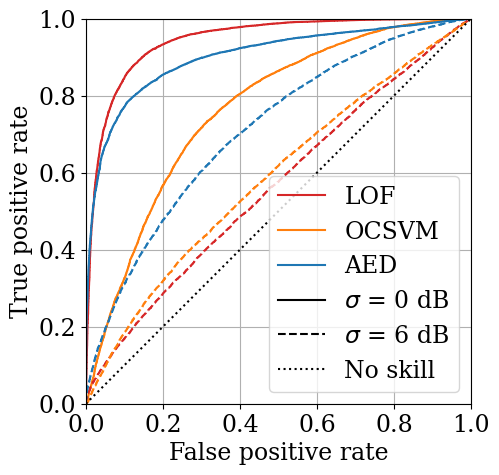

In [9]:
param = 'noise_std'

exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']

linestyle_by_config_idx = {0: '-', 1: '--'}

tx_pos_inaccuracy_std = 1.02

position = 'left' # position in paper, can be left, right or None
# right position in paper has limited labels to save space

font_size = plt.rcParams['font.size']
if position == 'left' or position == 'right':
    plt.rcParams['font.size'] = 17
else:
    plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (5,5)

def plot_roc_for_two_configs(grid_size, noise_std, config_idx):

    # Load results from file
    filename = description_file_utils.get_filename_by_params(filenames_table=filenames_table, \
                                                             noise_std=noise_std, \
                                                             grid_size=grid_size, \
                                                             tx_pos_inaccuracy_std=tx_pos_inaccuracy_std)
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pkl.load(f_results)

    # Calculate and plot the ROC curve for each method
    for method in results:
        
        if method in exclude_from_plot:
            continue

        if method == 'one_class_svm':
            fpr, tpr, thresholds = roc_curve(results[method]['y_test'], -results[method]['y_hat'])
        else:
            fpr, tpr, thresholds = roc_curve(results[method]['y_test'], results[method]['y_hat'])
        if noise_std == 0:
            global r
            r = results['one_class_svm']
        
        plt.plot(fpr, tpr, color=method_colors[method],
                 linestyle=linestyle_by_config_idx[config_idx],
                 label=f'{method_labels[method]}' if (config_idx == 0 and position != 'right') else None)


if param == 'noise_std':
    noise_std_by_config_idx = {0: 0, 1: 6}

    for config_idx in noise_std_by_config_idx:
        plot_roc_for_two_configs(10, noise_std_by_config_idx[config_idx], config_idx)
        plt.plot([], [], color='black', linestyle=linestyle_by_config_idx[config_idx],
                label='$\sigma$'+f' = {noise_std_by_config_idx[config_idx]} dB')
        
elif param == 'grid_size':
    grid_size_by_config_idx = {0: 10, 1: 5}

    for config_idx in grid_size_by_config_idx:
        plot_roc_for_two_configs(grid_size_by_config_idx[config_idx], 2, config_idx)
        plt.plot([], [], color='black', linestyle=linestyle_by_config_idx[config_idx],
                label=f'Grid size: {grid_size_by_config_idx[config_idx]} m')


# Plot the 50-50 line
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='No skill')

plt.xlabel('False positive rate')
if position != 'right':
    plt.ylabel('True positive rate')
else:
    locs, labels = plt.yticks()
    plt.yticks(locs, ['' for l in labels])
plt.gca().set_aspect('equal', 'box')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
if position in ['left', 'right']:
    figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', f'roc_curves-{param}_{position[0]}.pdf')
else:
    figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', f'roc_curves-{param}.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

plt.rcParams['font.size'] = font_size